
### 06. DCNet solution for split measurements
This tutorial shows how to perform image reconstruction using DCNet (data completion network) with
and without a trainable image denoiser. 


In [14]:
import numpy as np
import os
from spyrit.misc.disp import imagesc
import matplotlib.pyplot as plt

#### Load a batch of images



Shape of input images: torch.Size([7, 1, 64, 64])


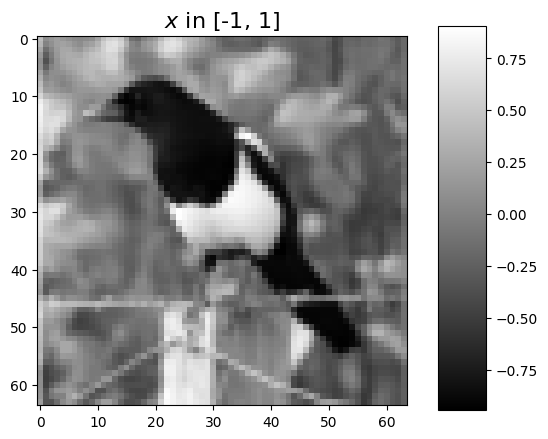

In [15]:

from spyrit.misc.statistics import transform_gray_norm
import torchvision
import torch

h = 64  # image size hxh
i = 1  # image index 
spyritPath = os.getcwd()
imgs_path = os.path.join(spyritPath, "../images")

# Tansform original image to normalized grayscale image tensors
transform = transform_gray_norm(img_size=h)

# Create dataset and load image
dataset = torchvision.datasets.ImageFolder(root=imgs_path, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=7)

x, _ = next(iter(dataloader))
print(f"Shape of input images: {x.shape}")

# Select image
x = x[i + 1 : i + 2, :, :, :]
x = x.detach().clone()
b, c, h, w = x.shape

# plot
x_plot = x.view(-1, h, h).cpu().numpy()
imagesc(x_plot[0, :, :], r"$x$ in [-1, 1]")

#### Forward operators for split measurements
We consider noisy split measurements for a Hadamard operator and a
"variance subsampling" strategy 


In [22]:
#we download the covariance matrix and load it.


import girder_client

# api Rest url of the warehouse
url = "https://pilot-warehouse.creatis.insa-lyon.fr/api/v1"

# Generate the warehouse client
gc = girder_client.GirderClient(apiUrl=url)

# Download the covariance matrix and mean image
data_folder = "./stat/"
dataId_list = [
    "63935b624d15dd536f0484a5",  # for reconstruction (imageNet, 64)
    "63935a224d15dd536f048496",  # for reconstruction (imageNet, 64)
]
cov_name = "./stat/Cov_64x64.npy"

try:
    for dataId in dataId_list:
        myfile = gc.getFile(dataId)
        gc.downloadFile(dataId, data_folder + myfile["name"])

    print(f"Created {data_folder}")

    Cov = np.load(cov_name)
    print(f"Cov matrix {cov_name} loaded")
    print(Cov)
except:
    Cov = np.eye(h * h)
    print(f"Cov matrix {cov_name} not found! Set to the identity")
    print(Cov)

Created ./stat/
Cov matrix ./stat/Cov_64x64.npy loaded
[[ 2.79830950e+06 -4.63127734e+03 -6.88842266e+04 ... -8.37627125e+00
  -1.41187000e+01 -1.48691435e+01]
 [-4.63127734e+03  2.18258719e+05  3.94270020e+02 ...  2.23225430e-01
   1.01451063e+00  1.63706913e+01]
 [-6.88842266e+04  3.94270020e+02  6.97157266e+04 ...  1.61120370e-01
   3.96517015e+00 -4.67280054e+00]
 ...
 [-8.37627125e+00  2.23225430e-01  1.61120370e-01 ...  8.92345619e+00
  -3.76183493e-03  4.08663481e-01]
 [-1.41187000e+01  1.01451063e+00  3.96517015e+00 ... -3.76183493e-03
   8.60720921e+00 -6.35975778e-01]
 [-1.48691435e+01  1.63706913e+01 -4.67280054e+00 ...  4.08663481e-01
  -6.35975778e-01  1.77011623e+01]]


We define the measurement, noise and preprocessing operators and then
simulate a noiseless measurement vector $y$.



Pseudo inverse will not be instanciated
Shape of vectorized image: torch.Size([1, 4096])


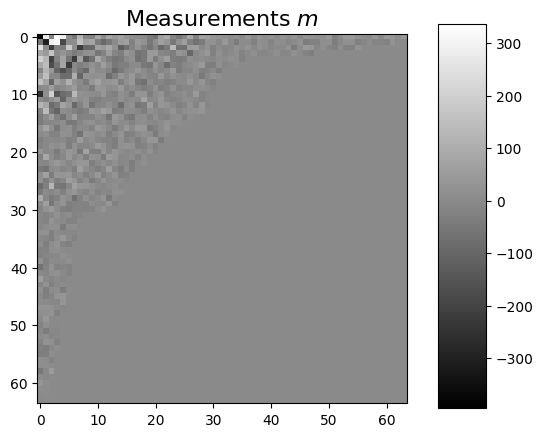

In [17]:
from spyrit.core.meas import HadamSplit
from spyrit.core.noise import Poisson
from spyrit.misc.sampling import meas2img2
from spyrit.misc.statistics import Cov2Var
from spyrit.core.prep import SplitPoisson

# Measurement parameters
M = 64 * 64 // 4  # Number of measurements (here, 1/4 of the pixels)
alpha = 100.0  # number of photons

# Ordering matrix
Ord = Cov2Var(Cov)

# Measurement and noise operators
meas_op = HadamSplit(M, h, Ord)
noise_op = Poisson(meas_op, alpha)
prep_op = SplitPoisson(alpha, meas_op)

# Vectorize image
x = x.view(b * c, h * w)
print(f"Shape of vectorized image: {x.shape}")

# Measurements
y = noise_op(x)  # a noisy measurement vector
m = prep_op(y)  # preprocessed measurement vector

m_plot = m.detach().numpy()
m_plot = meas2img2(m_plot.T, Ord)
imagesc(m_plot, r"Measurements $m$")

#### PinvNet network



In [18]:
from spyrit.core.recon import PinvNet
from spyrit.misc.disp import add_colorbar, noaxis

# Pseudoinverse reconstruction
pinvnet = PinvNet(noise_op, prep_op)

# ucheck if GPU present or not?
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Pseudo-inverse net
pinvnet = pinvnet.to(device)

# Reconstruction
with torch.no_grad():
    z_invnet = pinvnet.reconstruct(y.to(device))  # reconstruct from raw measurements

#### DCNet network
We can improve PinvNet results by using the *denoised* completion network DCNet with the

It has four sequential steps:

*  denoising of the acquired measurements,
* estimation of the missing measurements from the denoised ones,
* mapping them to the image domain, and
* denoising in the image-domain.




In [19]:
from spyrit.core.recon import DCNet
from spyrit.core.nnet import Unet
from torch import nn

# Reconstruction with for DCNet (linear net)
dcnet = DCNet(noise_op, prep_op, Cov, denoi=nn.Identity())
dcnet = dcnet.to(device)

# Reconstruction
with torch.no_grad():
    z_dcnet = dcnet.reconstruct(y.to(device))  # reconstruct from raw measurements

With a UNet denoising layer, we define the denoising network and
then load the pretrained weights.



In [20]:
from spyrit.core.train import load_net
import matplotlib.pyplot as plt
from spyrit.misc.disp import add_colorbar, noaxis

# Define UNet denoiser
denoi = Unet()

# Define DCNet (with UNet denoising)
dcnet_unet = DCNet(noise_op, prep_op, Cov, denoi)
dcnet_unet = dcnet_unet.to(device)

# Load previously trained model
try:
    import gdown

    # Download weights
    url_unet = "https://drive.google.com/file/d/15PRRZj5OxKpn1iJw78lGwUUBtTbFco1l/view?usp=drive_link"
    model_path = "./model"
    if os.path.exists(model_path) is False:
        os.mkdir(model_path)
        print(f"Created {model_path}")
    model_unet_path = os.path.join(
        model_path,
        "dc-net_unet_stl10_N0_100_N_64_M_1024_epo_30_lr_0.001_sss_10_sdr_0.5_bs_512_reg_1e-07",
    )
    gdown.download(url_unet, f"{model_path}.pth", quiet=False, fuzzy=True)

    # Load pretrained model
    load_net(model_path, dcnet_unet, device, False)
    print(f"Model {model_path} loaded.")
except:
    print(f"Model {model_path} not found!")
    load_unet = False

# Reconstruction
with torch.no_grad():
    z_dcnet_unet = dcnet_unet.reconstruct(
        y.to(device)
    )  # reconstruct from raw measurements

Downloading...
From (original): https://drive.google.com/uc?id=15PRRZj5OxKpn1iJw78lGwUUBtTbFco1l
From (redirected): https://drive.google.com/uc?id=15PRRZj5OxKpn1iJw78lGwUUBtTbFco1l&confirm=t&uuid=7352a88d-42b1-4ed9-a159-09be836d18a0
To: c:\Users\RAmsh\OneDrive\Desktop\gjbhjbkhb\spyrit-master\spyrit\tutorial\model.pth
100%|██████████| 149M/149M [00:44<00:00, 3.34MB/s] 


Model Loaded: ./model
Model ./model loaded.


We plot all results



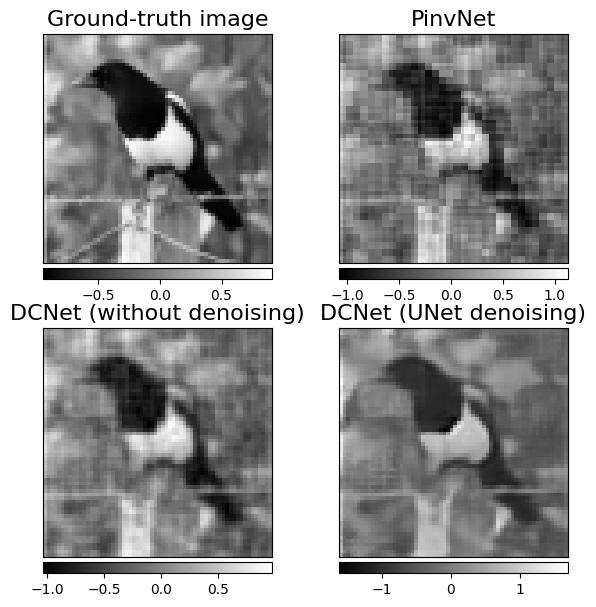

In [25]:
# plot reconstruction side by side
x_plot = x.view(-1, h, h).cpu().numpy()
x_plot2 = z_invnet.view(-1, h, h).cpu().numpy()
x_plot3 = z_dcnet.view(-1, h, h).cpu().numpy()
x_plot4 = z_dcnet_unet.view(-1, h, h).cpu().numpy()

f, axs = plt.subplots(2, 2, figsize=(7, 7))
im1 = axs[0, 0].imshow(x_plot[0, :, :], cmap="gray")
axs[0, 0].set_title("Ground-truth image", fontsize=16)
noaxis(axs[0, 0])
add_colorbar(im1, "bottom")

im2 = axs[0, 1].imshow(x_plot2[0, :, :], cmap="gray")
axs[0, 1].set_title("PinvNet", fontsize=16)
noaxis(axs[0, 1])
add_colorbar(im2, "bottom")

im3 = axs[1, 0].imshow(x_plot3[0, :, :], cmap="gray")
axs[1, 0].set_title(f"DCNet (without denoising)", fontsize=16)
noaxis(axs[1, 0])
add_colorbar(im3, "bottom")

im4 = axs[1, 1].imshow(x_plot4[0, :, :], cmap="gray")
axs[1, 1].set_title(f"DCNet (UNet denoising)", fontsize=16)
noaxis(axs[1, 1])
add_colorbar(im4, "bottom")

plt.show()

In [26]:
import numpy as np

# Calculate signal power (total number of photons)
signal_power = np.sum(x_plot ** 2)  # Squared L2 norm of the original signal

# Calculate noise power for each reconstructed image
noise_power_invnet = np.sum((x_plot - x_plot2) ** 2)  # Squared L2 norm of the difference
noise_power_dcnet = np.sum((x_plot - x_plot3) ** 2)  # Squared L2 norm of the difference
noise_power_dcnet_unet = np.sum((x_plot - x_plot4) ** 2)  # Squared L2 norm of the difference

# Calculate SNR for each reconstructed image
SNR_invnet = 10 * np.log10(signal_power / noise_power_invnet)
SNR_dcnet = 10 * np.log10(signal_power / noise_power_dcnet)
SNR_dcnet_unet = 10 * np.log10(signal_power / noise_power_dcnet_unet)

print("SNR for Inverse Net Reconstruction:", SNR_invnet)
print("SNR for DC Net Reconstruction:", SNR_dcnet)
print("SNR for DC Net with U-Net Reconstruction:", SNR_dcnet_unet)


SNR for Inverse Net Reconstruction: 10.188713073730469
SNR for DC Net Reconstruction: 11.677420139312744
SNR for DC Net with U-Net Reconstruction: 7.705724835395813
